# Self-Improving Math Reasoning Data Distillation from DeepSeek R1 with CAMEL

You can also check this cookbook in colab [here](https://colab.research.google.com/drive/1_u8mKhj-6t09NrebX6ru4HW9jpu3BcmJ?usp=sharing)

<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on [*Github*](https://github.com/camel-ai/camel), join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)
</div>



This notebook introduces CAMEL's powerful self-improving data distillation pipeline, specifically designed to generate high-quality reasoning datasets. By incorporating self-improvement through iterative refinement, CAMEL enables the creation of long chain-of-thought (CoT) data with detailed reasoning processes.

What Makes This Approach Special?

- Self-Improvement: The key feature of this pipeline is the ability to iteratively improve reasoning traces. By setting evaluation agent and a maximum number of iterations (e.g., max_iterations=2), the reasoning process is enhanced step by step, improve the quality of the solutions.

- Reasoning Trace Generation: CAMEL generates detailed reasoning for each mathematical problem. The generated traces are continuously evaluated, and based on feedback, they are refined and improved.

Through CAMEL’s self-improvement mechanism, we ensure that the generated reasoning data continuously evolves, producing high-quality synthetic data that enhance problem-solving skills.

Through the use of our synthetic data generation pipeline, CAEML-AI has crafted three comprehensive datasets that are now available to enhance your mathematical reasoning and problem-solving skills. These datasets are hosted on Hugging Face for easy access:

- **📚 AMC AIME STaR Dataset**

  A dataset of 4K advanced mathematical problems and solutions, distilled with improvement history showing how the solution was iteratively refined.
  🔗 [Explore the Dataset](https://huggingface.co/datasets/camel-ai/amc_aime_star)  

- **📚 AMC AIME Distilled Dataset**

  A dataset of 4K advanced mathematical problems and solutions, distilled with clear step-by-step solutions. 🔗 [Explore the Dataset](https://huggingface.co/datasets/camel-ai/amc_aime_distilled)  

- **📚 GSM8K Distilled Dataset**

  A dataset of 7K high quality linguistically diverse grade school math word problems and solutions, distilled with clear step-by-step solutions. 🔗 [Explore the Dataset](https://huggingface.co/datasets/camel-ai/gsm8k_distilled)   


Perfect for those eager to explore AI-driven problem-solving or dive deep into mathematical reasoning! 🚀✨

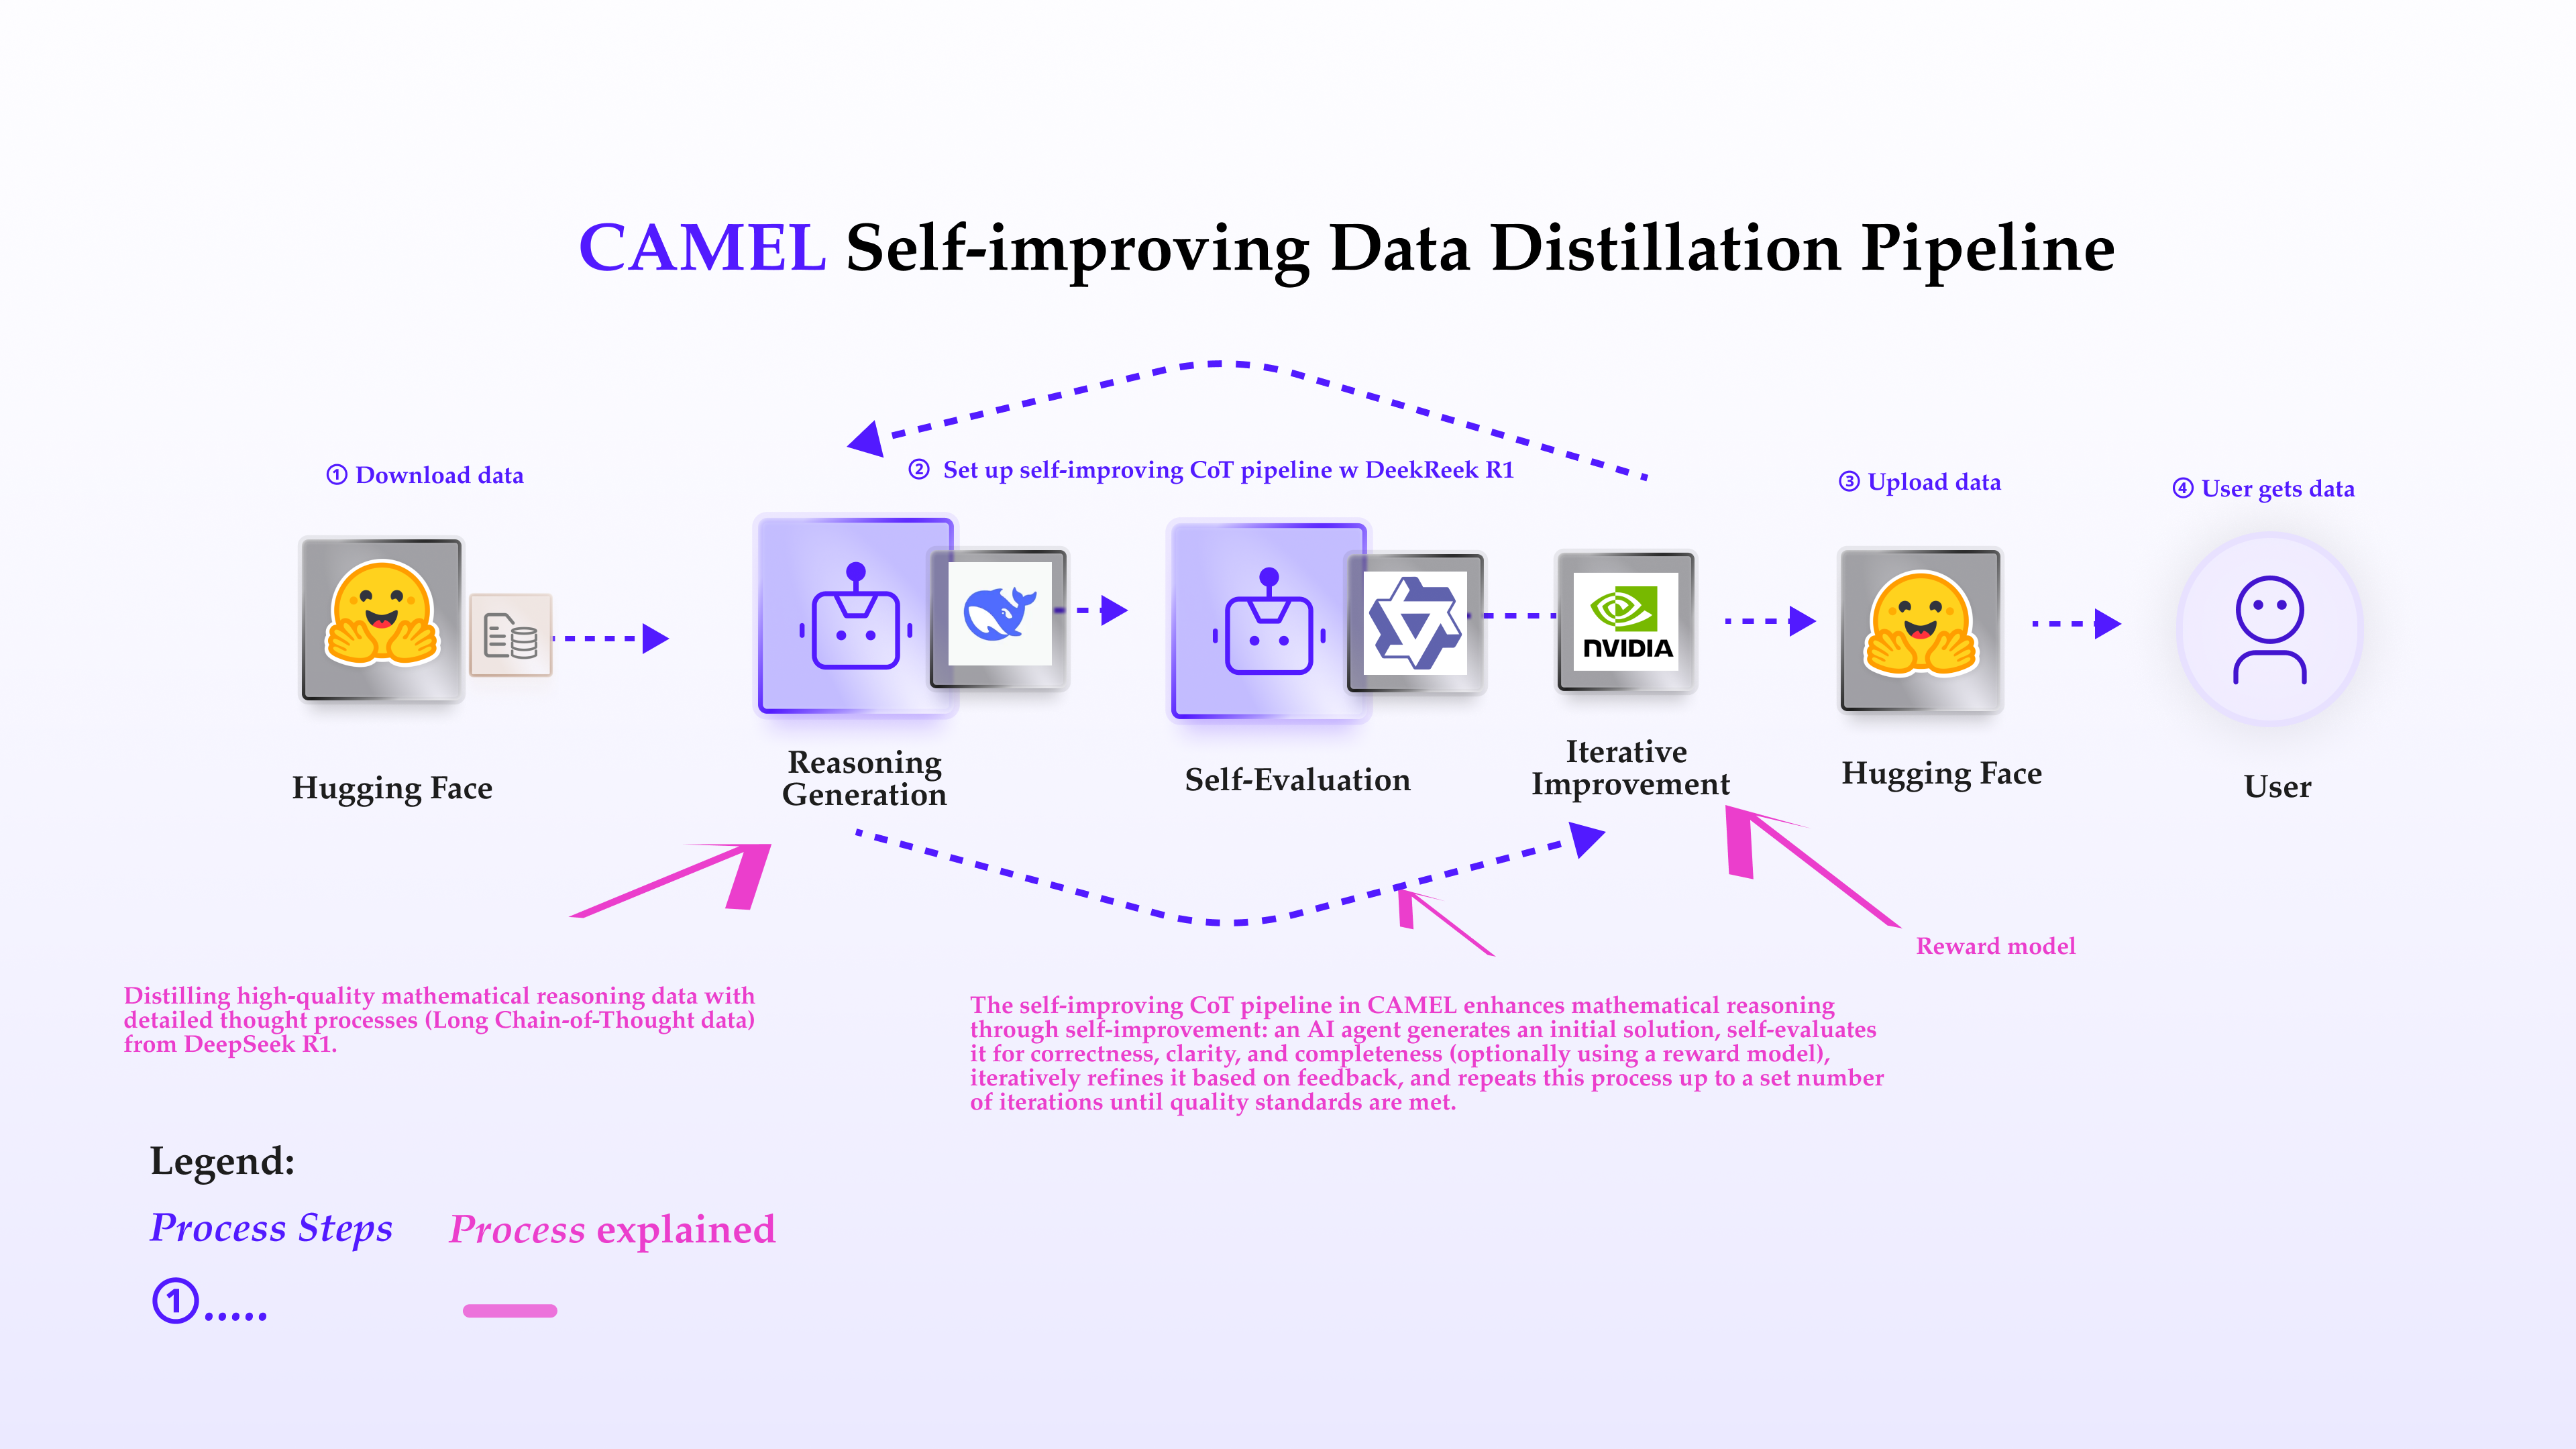

## 📦 Installation

Firstly, we need to install the camel-ai package for datagen pipeline

In [1]:
%%capture
!pip install "git+https://github.com/camel-ai/camel.git@f028e39fb2fbedcd30f43036899d3d13e5c25b01#egg=camel-ai"
!pip install datasets
!pip install rouge

## 🔑 Setting Up API Keys

Let's set the `FIREWORKS_API_KEY` or `DEEPSEEK_API_KEY` that will be used to distill the maths reasoning data with thought process.

⭐ **NOTE**: You could also use other model provider like Together AI, SilionFlow

In [2]:
from getpass import getpass
import os

In [3]:
FIREWORKS_API_KEY = getpass('Enter your FIREWORKS_API_KEY: ')
os.environ["FIREWORKS_API_KEY"] = FIREWORKS_API_KEY

Enter your FIREWORKS_API_KEY: ··········


In [ ]:
DEEPSEEK_API_KEY = getpass('Enter your DEEPSEEK_API_KEY: ')
os.environ["DEEPSEEK_API_KEY"] = DEEPSEEK_API_KEY

Enter your DEEPSEEK_API_KEY: ··········


Alternatively, if running on Colab, you could save your API keys and tokens as **Colab Secrets**, and use them across notebooks.

To do so, **comment out** the above **manual** API key prompt code block(s), and **uncomment** the following codeblock.

⚠️ Don't forget granting access to the API key you would be using to the current notebook.

In [ ]:
# import os
# from google.colab import userdata

# os.environ["FIREWORKS_API_KEY"] = userdata.get("FIREWORKS_API_KEY")
# os.environ["DEEPSEEK_API_KEY"] = userdata.get("DEEPSEEK_API_KEY")

In [ ]:
#to make deepseek r1 responds with thought process content,we should set the following environment variable
os.environ["GET_REASONING_CONTENT"]="True"

## 📥 Download Dataset from Hugging Face and Convert to the Desired Format


Now, lets start to prepare the original maths  data from Hugging Face ,which mainly have two important key: questions and answers. We will use GSM8K as example.

In [4]:
# Set the number of problems to download from GSM8K in huggingface
NUMBER_OF_PROBLEMS=5

After we download these datasets, we will convert these datasets to the desired format which suitable to be used in **CAMEL's data distillation pipeline**.

In [5]:
import json
from pathlib import Path
import uuid
from datasets import load_dataset

def download_gsm8k_dataset():
    try:
        # Load the dataset using the datasets library
        dataset = load_dataset("openai/gsm8k", "main")

        # Get the first 5 items from train split
        data = dataset['train'].select(range(NUMBER_OF_PROBLEMS))

        # Convert to the desired format
        formatted_data = []
        for item in data:
            # Extract the final answer from the solution
            solution = item['answer']
            if solution:
                # GSM8K solutions typically end with "#### number"
                import re

                match = re.search(r'####\s*(\d+)', solution)
                if match:
                    number = match.group(1)
                    # Replace the "#### number" with "\boxed{number}"
                    solution = re.sub(
                        r'####\s*\d+', f'\\\\boxed{{{number}}}', solution
                    )

            formatted_item = {
                "id": str(uuid.uuid4()),  # GSM8K doesn't provide IDs
                "problem": item['question'],
                "type": "openai/gsm8k",  # All problems are from GSM8K
                "solution": solution,  # Use the modified solution with \boxed
            }
            formatted_data.append(formatted_item)

        # Save to a file
        output = formatted_data
        output_file = "downloaded_gsm8k_10.json"
        with open(output_file, "w") as f:
            json.dump(output, f, indent=2)

        print(f"Successfully downloaded and saved GSM8K dataset to {output_file}")
    except Exception as e:
        print(f"Error downloading GSM8K dataset: {e}")

if __name__ == "__main__":
    download_gsm8k_dataset()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Successfully downloaded and saved GSM8K dataset to downloaded_gsm8k_10.json


Cool! Now you have already got some desired format example data,lets move to start to distill some maths reasoning data with thought process.

## 🚀 Begin Distilling Mathematical Reasoning Data with Thought Process (Long CoT Data).

The Self-Improving CoT Pipeline is at the heart of CAMEL’s self-improving mechanism. It generates reasoning traces, evaluates them, and refines them iteratively. The pipeline executes the following core steps:

- Initial Reasoning Generation: For each problem, an initial reasoning trace is created by the agent.

- Self-Evaluation: The agent evaluates the trace for correctness, clarity, and completeness. We also support evaluation with reward model

- Iterative Improvement: Based on the evaluation feedback, the reasoning trace is iteratively improved, ensuring enhanced logic and clarity with each iteration.

Final Refinement: The pipeline repeats the feedback loop up to max_iterations=2 times (you can adjust this number), continuously refining the reasoning until it meets the desired quality.

Import required libraries:

In [7]:
import nest_asyncio
nest_asyncio.apply()

import json
import os
import time

from camel.agents import ChatAgent
from camel.datagen import SelfImprovingCoTPipeline
from camel.models import ModelFactory
from camel.types import ModelPlatformType, ModelType

Next, let's set up the reasoning model and evaluate model. Since the DeepSeek's API service is currently unstable, we will also set DeepSeek R1 served by [Fireworks](https://fireworks.ai/). CAMEL's model manager to automatically switch models based on the success of the request.

In [8]:
# Set llama3.3 70b as evaluate model
evaluate_model = ModelFactory.create(
    model_platform=ModelPlatformType.OPENAI_COMPATIBLE_MODEL,
    model_type="accounts/fireworks/models/llama-v3p3-70b-instruct",
    api_key=os.environ["FIREWORKS_API_KEY"],
    url="https://api.fireworks.ai/inference/v1",
)


# Set DeepSeek R1 served by Fireworks as reason model 1
reason_model_1 = ModelFactory.create(
    model_platform=ModelPlatformType.OPENAI_COMPATIBLE_MODEL,
    model_type="accounts/fireworks/models/deepseek-r1",
    api_key=os.environ["FIREWORKS_API_KEY"],
    url="https://api.fireworks.ai/inference/v1",
    model_config_dict={"max_tokens": 2000}, # Config the max_token carefully
)

# Set DeepSeek R1 served by deepseek cloud as reason model 2
reason_model_2 = ModelFactory.create(
    model_platform=ModelPlatformType.DEEPSEEK,
    model_type=ModelType.DEEPSEEK_REASONER,
)

Now we can start to execute CAMEL's SelfImprovingCoTPipeline.

In [ ]:
start_time = time.time()
problems_path = "downloaded_gsm8k_10.json"
output_path = "generated_data.json"

# Load problems from JSON file
with open(problems_path, 'r') as f:
    problems = json.load(f)

# Initialize agent
reason_agent_system_message = """Answer my question and give your
final answer within \\boxed{}."""
evaluate_agent_system_message = """You are a highly critical teacher who
evaluates the student's answers with a meticulous and demanding approach.
"""

# Set up reason agent
reason_agent = ChatAgent(
    system_message=reason_agent_system_message,
    model=[reason_model_1, reason_model_2], # add models to the list
)

# Set up evaluate agent
evaluate_agent = ChatAgent(
    system_message=evaluate_agent_system_message,
    model=evaluate_model,
)

# # Initialize reward model (optional)
# reward_model = NemotronRewardModel(
#     model_type=ModelType.NVIDIA_NEMOTRON_340B_REWARD,
#     url="https://integrate.api.nvidia.com/v1",
#     api_key=os.environ.get("NVIDIA_API_KEY"),
# )

# Set score thresholds for different dimensions (optional)
score_threshold = {
    "correctness": 1.0,
    "clarity": 0.0,
    "completeness": 0.0,
}
# # Or use a single threshold for all dimensions:
# score_threshold = 0.9


# Create and run pipeline
pipeline = SelfImprovingCoTPipeline(
    reason_agent=reason_agent,
    problems=problems,  # Pass problems list directly
    output_path=output_path,
    max_iterations=2,
    batch_size=100, # Size of batch to process the data (optional)
    evaluate_agent=evaluate_agent, # To use evaluate agent(optional)
    score_threshold=score_threshold, # Score thresholds for agent evaluation (optional)
    # reward_model=reward_model,  # To use a reward model (optional)
)
print("Start generation! May take some time, please wait..")
results = pipeline.generate(rationalization=True)

end_time = time.time()
execution_time = end_time - start_time

print(f"\nProcessed {len(results)} problems")
print(f"Results saved to: {output_path}")
print(f"Total execution time: {execution_time:.2f} seconds")

Let's take a look at generated reasoning data!

In [11]:
with open('generated_data.json', 'r') as f:
    data = json.load(f)
    print(json.dumps(data, indent=2))

{
  "traces": [
    {
      "id": "ef030085-71cb-44b8-a8d2-613c0abe6dee",
      "type": "openai/gsm8k",
      "problem": "Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?",
      "solution": "Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n\\boxed{72}",
      "final_trace": "<think>\nOkay, so the user wants me to improve the reasoning trace based on the feedback they received. Let me start by understanding the original problem and solution again.\n\nThe problem says Natalia sold clips to 48 friends in April and then half as many clips in May. The solution calculated May as 24 clips (half of 48) and total as 72, which seems straightforward. But the feedback mentioned that assumptions should be more explicitly justified and that units should be verified throughout.\n\nFirst, the key point here is clarifying the

##  📤 Upload the Data to Hugging Face

After we've distilled the desired data, let's upload it to Hugging Face and share it with more people!

Define the dataset upload pipeline, including steps like creating records, generating a dataset card, and other necessary tasks.

In [ ]:
# Import necessary modules and classes
from camel.datahubs.huggingface import HuggingFaceDatasetManager  # Manages interactions with Hugging Face datasets
from camel.datahubs.models import Record  # Represents a single record in the dataset
from datetime import datetime  # Handles date and time operations
import json  # For reading JSON files

def load_star_output(file_path):
    r"""Load and parse the star output JSON file.

    Args:
        file_path (str): Path to the star_output.json file.

    Returns:
        list: List of traces from the JSON file.
    """
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data['traces']

# Main function: Upload dataset to Hugging Face
def upload_to_huggingface(transformed_data, username, dataset_name=None):
    r"""Uploads transformed data to the Hugging Face dataset platform.

    Args:
        transformed_data (list): Transformed data, typically a list of dictionaries.
        username (str): Hugging Face username.
        dataset_name (str, optional): Custom dataset name.

    Returns:
        str: URL of the uploaded dataset.
    """
    # Initialize HuggingFaceDatasetManager to interact with Hugging Face datasets
    manager = HuggingFaceDatasetManager()

    # Generate or validate the dataset name
    dataset_name = generate_or_validate_dataset_name(username, dataset_name)

    # Create the dataset on Hugging Face and get the dataset URL
    dataset_url = create_dataset(manager, dataset_name)

    # Create a dataset card to add metadata
    create_dataset_card(manager, dataset_name, username)

    # Convert the transformed data into a list of Record objects
    records = create_records(transformed_data)

    # Add the Record objects to the dataset
    add_records_to_dataset(manager, dataset_name, records)

    # Return the dataset URL
    return dataset_url

# Generate or validate the dataset name
def generate_or_validate_dataset_name(username, dataset_name):
    r"""Generates a default dataset name or validates and formats a user-provided name.

    Args:
        username (str): Hugging Face username.
        dataset_name (str, optional): User-provided custom dataset name.

    Returns:
        str: Formatted dataset name.
    """
    if dataset_name is None:
        # If no dataset name is provided, generate a default name with the username and current date
        current_date = datetime.now().strftime("%Y%m%d")
        dataset_name = f"star_traces_{current_date}"

    # Format the dataset name to include the username
    return f"{username}/{dataset_name}"

# Create a dataset on Hugging Face
def create_dataset(manager, dataset_name):
    r"""Creates a new dataset on Hugging Face and returns the dataset URL.

    Args:
        manager (HuggingFaceDatasetManager): Instance of HuggingFaceDatasetManager.
        dataset_name (str): Name of the dataset.

    Returns:
        str: URL of the created dataset.
    """
    dataset_url = manager.create_dataset(dataset_name)
    return dataset_url

# Create a dataset card with metadata
def create_dataset_card(manager, dataset_name, username):
    r"""Creates a dataset card to add metadata

    Args:
        manager (HuggingFaceDatasetManager): Instance of HuggingFaceDatasetManager.
        dataset_name (str): Name of the dataset.
        username (str): Hugging Face username.
    """
    manager.create_dataset_card(
        dataset_name=dataset_name,
        description="A dataset containing mathematical problem-solving traces with step-by-step solutions and improvement history. Each record includes a mathematical problem, its final solution, and the iterative improvement process.",
        license="mit",  # Using lowercase 'mit' as required by HuggingFace
        tags=["math", "problem-solving", "step-by-step", "traces"],
        authors=[username],
        language=["en"],
        task_categories=["text-generation"],
        content="This dataset contains mathematical problem-solving traces generated using the CAMEL framework. Each entry includes:\n\n"
                "- A mathematical problem statement\n"
                "- A detailed step-by-step solution\n"
                "- An improvement history showing how the solution was iteratively refined"
    )

# Convert transformed data into Record objects
def create_records(transformed_data):
    r"""Converts transformed data into a list of Record objects.

    Args:
        transformed_data (list): List of trace dictionaries from star_output.json.

    Returns:
        list: List of Record objects.
    """
    records = []
    for trace in transformed_data:
        record = Record(
            id=trace['id'],
            source_type=trace['type'],
            problem=trace['problem'],
            reasoning_solution=trace['final_trace'],
            groud_truth_solution=trace['solution'],
            agent_evaluate_success=trace['evaluate_success'],
            boxed_answer_success=trace['boxed_answer_success'],
            improvement_history=trace['improvement_history'],
        )
        records.append(record)
    return records

# Add Record objects to the dataset
def add_records_to_dataset(manager, dataset_name, records):
    r"""Adds a list of Record objects to the dataset.

    Args:
        manager (HuggingFaceDatasetManager): Instance of HuggingFaceDatasetManager.
        dataset_name (str): Name of the dataset.
        records (list): List of Record objects.
    """
    manager.add_records(dataset_name, records)


### 🔑 Config Access Token of Hugging Face and Upload the Data

You can go to [here](https://huggingface.co/settings/tokens/new?tokenType=write) to get API Key from Hugging Face, also make sure you have opened the write access to repository.

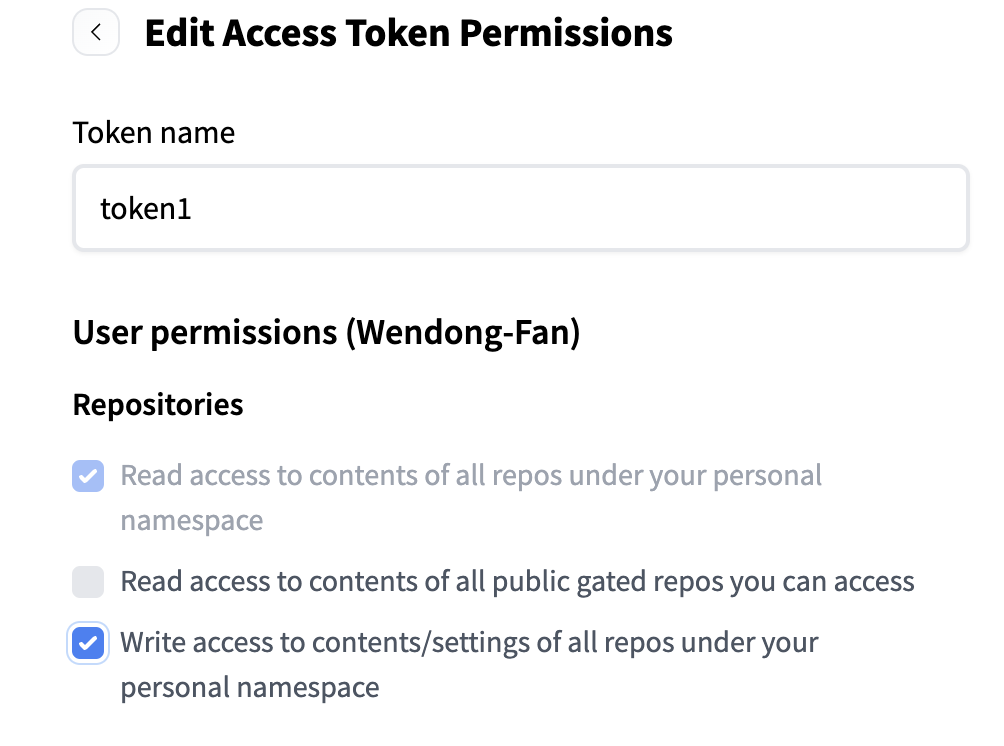

Then create a New Dataset in Hugging Face:

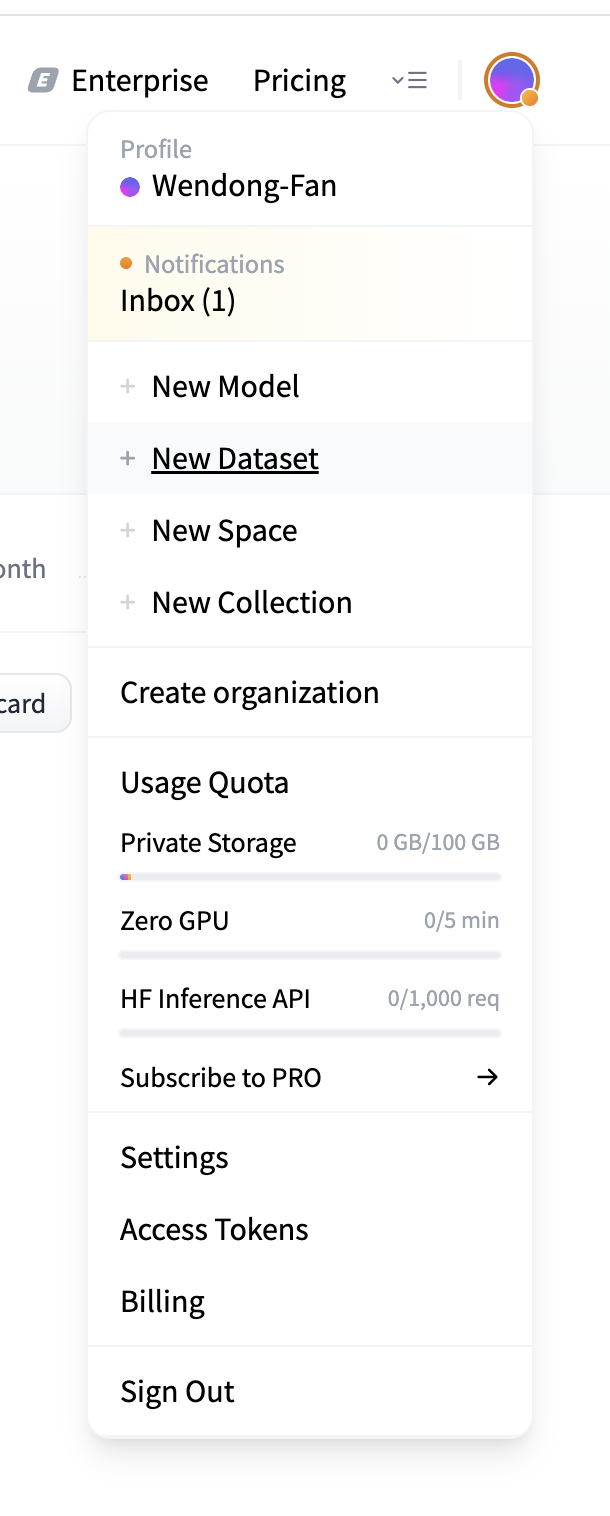

In [ ]:
# Get HuggingFace token and username
HUGGING_FACE_TOKEN = getpass('Enter your HUGGING_FACE_TOKEN: ')
os.environ["HUGGING_FACE_TOKEN"] = HUGGING_FACE_TOKEN

# Alternatively, to retrieve HF token from Colab Secrets instead
# import os
# from google.colab import userdata

# os.environ["HUGGING_FACE_TOKEN"] = userdata.get("HUGGING_FACE_TOKEN")

username = input("Enter your HuggingFace username: ")
dataset_name = input("Enter your dataset name:")


# Load the star output data
current_dir = os.getcwd()
star_output_path = os.path.join(current_dir, './generated_data.json')
traces = load_star_output(star_output_path)

# Upload the data to HuggingFace
dataset_url = upload_to_huggingface(traces, username, dataset_name)
print(f"\nDataset uploaded successfully!")
print(f"You can view your dataset at: {dataset_url}")


Enter your HUGGING_FACE_TOKEN: ··········
Enter your HuggingFace username: Wendong-Fan
Enter your dataset name:camel_dataset_example

Dataset uploaded successfully!
You can view your dataset at: https://huggingface.co/datasets/Wendong-Fan/camel_dataset_example


## 📊 Final Uploaded Data Preview

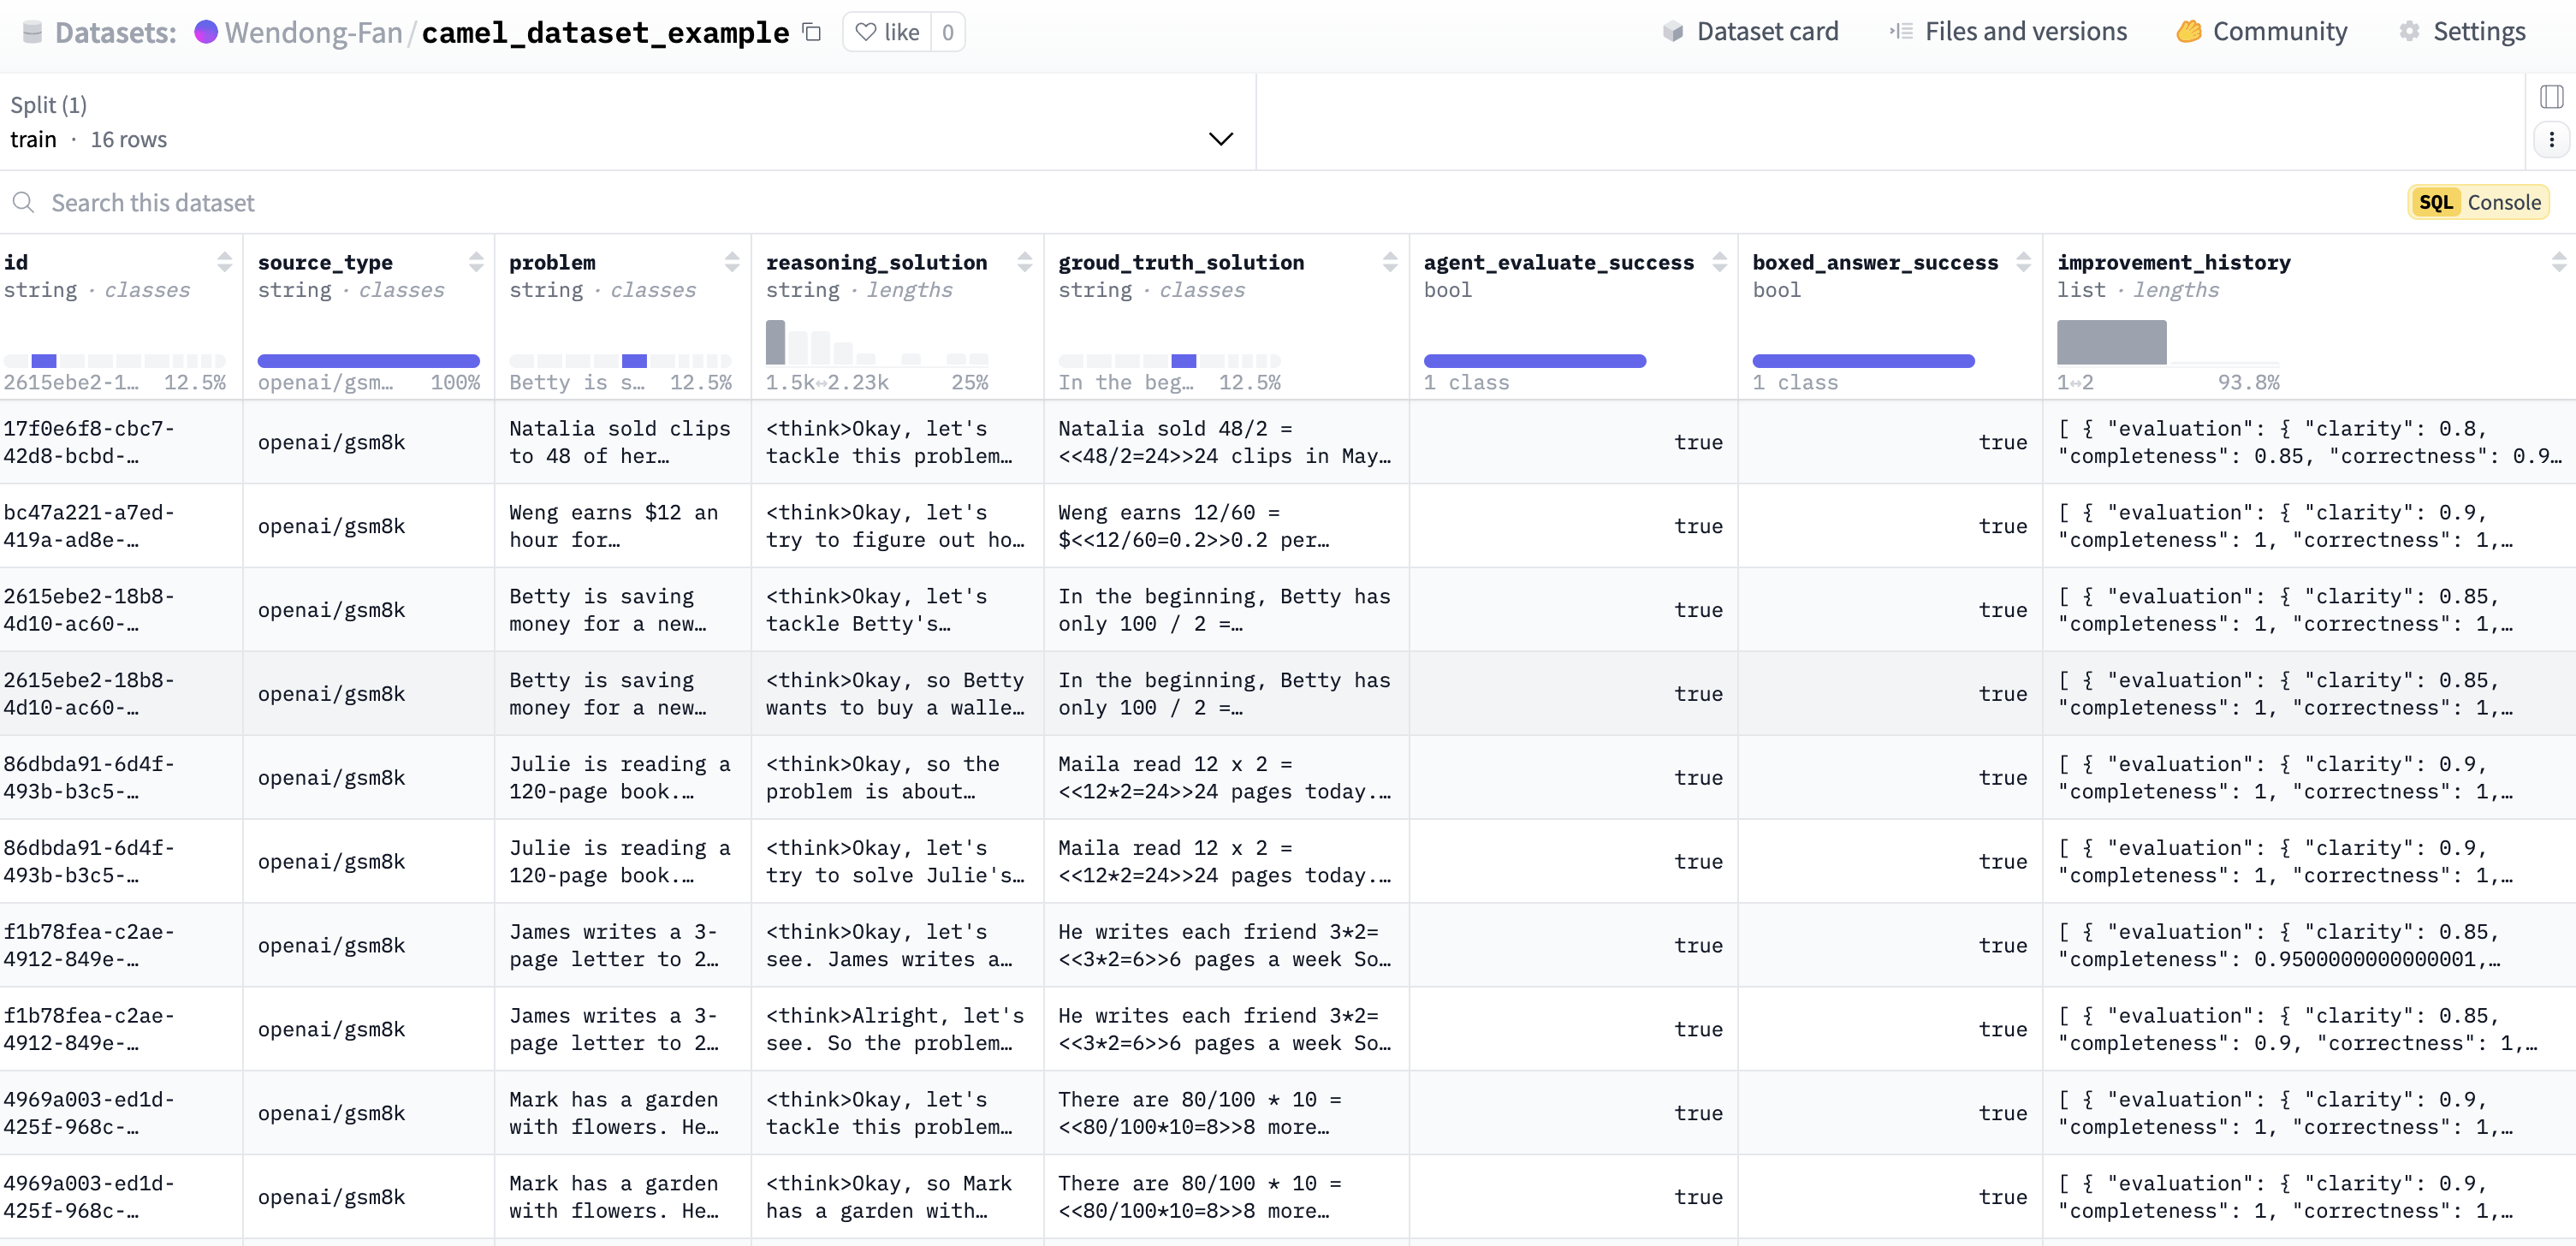

## 🌟 Highlights

The Self-Improving CoT Pipeline is a cutting-edge tool for generating long chain-of-thought reasoning data. By leveraging multiple iterations of evaluation and improvement, the pipeline creates high-quality reasoning traces that are perfect for advanced problem-solving and educational purposes. While the computational cost is significant, the resulting high-quality output is invaluable for building high quality synthetic data for model training.

That’s everything! If you have questions or need support, feel free to join us on Discord. Whether you want to share feedback, explore the latest in multi-agent systems, or connect with others, we’d love to have you in the community! 🤝

That's everything: Got questions about 🐫 CAMEL-AI? Join us on [Discord](https://discord.camel-ai.org)! Whether you want to share feedback, explore the latest in multi-agent systems, get support, or connect with others on exciting projects, we’d love to have you in the community! 🤝

Check out some of our other work:

1. 🐫 Creating Your First CAMEL Agent [free Colab](https://docs.camel-ai.org/cookbooks/create_your_first_agent.html)

2.  Graph RAG Cookbook [free Colab](https://colab.research.google.com/drive/1uZKQSuu0qW6ukkuSv9TukLB9bVaS1H0U?usp=sharing)

3. 🧑‍⚖️ Create A Hackathon Judge Committee with Workforce [free Colab](https://colab.research.google.com/drive/18ajYUMfwDx3WyrjHow3EvUMpKQDcrLtr?usp=sharing)

4. 🔥 3 ways to ingest data from websites with Firecrawl & CAMEL [free Colab](https://colab.research.google.com/drive/1lOmM3VmgR1hLwDKdeLGFve_75RFW0R9I?usp=sharing)

5. 🦥 Agentic SFT Data Generation with CAMEL and Mistral Models, Fine-Tuned with Unsloth [free Colab](https://colab.research.google.com/drive/1lYgArBw7ARVPSpdwgKLYnp_NEXiNDOd-?usp=sharingg)

Thanks from everyone at 🐫 CAMEL-AI


<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on [*Github*](https://github.com/camel-ai/camel), join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)
</div>
